# Figure Generation

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.fft import fftshift
import seaborn as sns
import matplotlib.pylab as pl
import bites as bt
from os import sep
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import ConnectionPatch
import matplotlib.animation as animation
from IPython.display import HTML, display

In [2]:
plt.rcParams['pdf.fonttype'] = 42

Extract data directory and metadata. 

In [3]:
dataDir = 'raw/JK_biting_paper_trained_data_04092025'
metaDat = 'video_parameters_04172025.csv'
plot_folder = r"plots/"

In [4]:
datasetDf = pd.read_csv(sep.join([dataDir, metaDat])).rename(columns={'Unnamed: 0': 'video'})
datasetDf['path'] = datasetDf['video'].apply(lambda x: sep.join([dataDir, x.replace('vid', dataDir.split(sep)[-1].split('_')[-1])]))
datasetDf['filename'] = datasetDf['video'].apply(lambda x: x.replace('vid','data')+'.csv')
datasetDf['videofile'] = datasetDf['video'].apply(lambda x: x+'.mp4')

In [5]:
datasetDf

,video,Frame rate (fps),Shutter speed: 1/frame (sec),resolution,frame count,rec. duration (sec),twist direction,frame1,frame2,frame3,path,filename,videofile
0,Skin_Pierce1_trim_48_trained_vid,250,0.004,1024 x 1024,1216,4.864,1,425,600,821,raw/JK_biting_paper_trained_data_04092025/Skin...,Skin_Pierce1_trim_48_trained_data.csv,Skin_Pierce1_trim_48_trained_vid.mp4
1,Vessel_Search_1_Pierce2_trim_48_trained_vid,250,0.004,1024 x 1024,3517,14.068,1,640,1096,1531,raw/JK_biting_paper_trained_data_04092025/Vess...,Vessel_Search_1_Pierce2_trim_48_trained_data.csv,Vessel_Search_1_Pierce2_trim_48_trained_vid.mp4
2,Vessel_searchg_findg_2_Pierce3_2_trim_57_train...,125,0.008,1024 x 1024,1016,8.128,-1,137,355,738,raw/JK_biting_paper_trained_data_04092025/Vess...,Vessel_searchg_findg_2_Pierce3_2_trim_57_train...,Vessel_searchg_findg_2_Pierce3_2_trim_57_train...
3,BFeed_trim_53_trained_vid,125,0.008,1024 x 1024,5082,40.656,1,686,2812,4507,raw/JK_biting_paper_trained_data_04092025/BFee...,BFeed_trim_53_trained_data.csv,BFeed_trim_53_trained_vid.mp4
4,Retract_Withdraw_trim3_46_trained_vid,250,0.004,1024 x 1024,786,3.144,1,125,302,360,raw/JK_biting_paper_trained_data_04092025/Retr...,Retract_Withdraw_trim3_46_trained_data.csv,Retract_Withdraw_trim3_46_trained_vid.mp4


Specify video index.

In [6]:
videoIdx = 4

In [7]:
vid_folder = datasetDf['path'].iloc[videoIdx]
filename = datasetDf['filename'].iloc[videoIdx]
vidfile = datasetDf['videofile'].iloc[videoIdx]
legDf = pd.read_csv(sep.join([vid_folder,filename]),header=[1,2],index_col=0)

camera_fps = datasetDf['Frame rate (fps)'].iloc[videoIdx] #camera fps
n = len(legDf)
T = n/camera_fps

Extract bite session from labium data. The `lab3` anchor point should not move much during biting.

In [8]:
vel_lab3 = np.sqrt((((legDf.loc[:,('lab3',
                'x')].diff())**2).values)+(((legDf.loc[:,('lab3',
                'y')].diff())**2).values))

In [9]:
window = 0.1
vel_lim = 5

In [10]:
ma = bt.moving_average((vel_lab3 <= vel_lim) | np.isnan(vel_lab3), window=window, T=T) >= 0.99
starts, ends = np.where(np.diff(np.concatenate(([0], ma, [0]))) == 1)[0], np.where(np.diff(np.concatenate(([0], ma, [0]))) == -1)[0]
longest = np.argmax(ends - starts)
t_bite_start, t_bite_end = starts[longest] * (T/n), ends[longest] * (T/n)
t_bite = t_bite_end-t_bite_start
print("bite start: ", t_bite_start, "; bite end: ", t_bite_end)

bite start:  0.0 ; bite end:  1.348


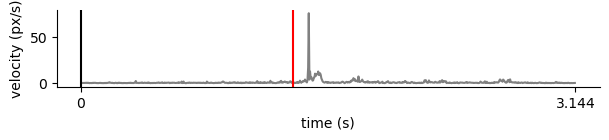

In [11]:
plt.figure(figsize = (7,1))
plt.plot(vel_lab3,color='gray');
plt.axvline(t_bite_start*n/T,color='k'); plt.axvline(t_bite_end*n/T,color='r');
sns.despine();
plt.xticks([0,n],[0,T]); plt.xlabel('time (s)'); plt.ylabel('velocity (px/s)');
plt.savefig(plot_folder+f"panel_{videoIdx}_"+"bite_segmentation.pdf",bbox_inches = "tight")

## Moving to Labium Frame

In [12]:
time = np.linspace(0,t_bite,round(n*t_bite/T))

In [13]:
parts = ('tar1','tar2','tar3','lab1','lab2','lab3','pal1','pal2','pal3')

In [14]:
derDf = bt.derive(legDf,T,t_bite_start,t_bite_end,ctr='lab3')

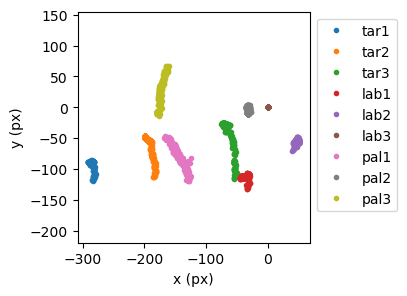

In [15]:
plt.figure(figsize = (3,3))
plt.axes().set_aspect('equal');
plt.plot(derDf.loc[:,(parts,('x'))].values,
         derDf.loc[:,(parts,('y'))].values,'.');
plt.axis('equal')
plt.legend(list(parts),bbox_to_anchor = (1,1));
plt.xlabel('x (px)'); plt.ylabel('y (px)');
plt.savefig(plot_folder+f"panel_{videoIdx}_"+"bodyparts_labium_frame_xy.pdf",bbox_inches = "tight")

In [16]:
# Load the video
video = bt.videoExtract(sep.join([vid_folder, vidfile]))
video_bite = video[int(t_bite_start*n/T):int(t_bite_end*n/T),:,:,:]

## Panel 1

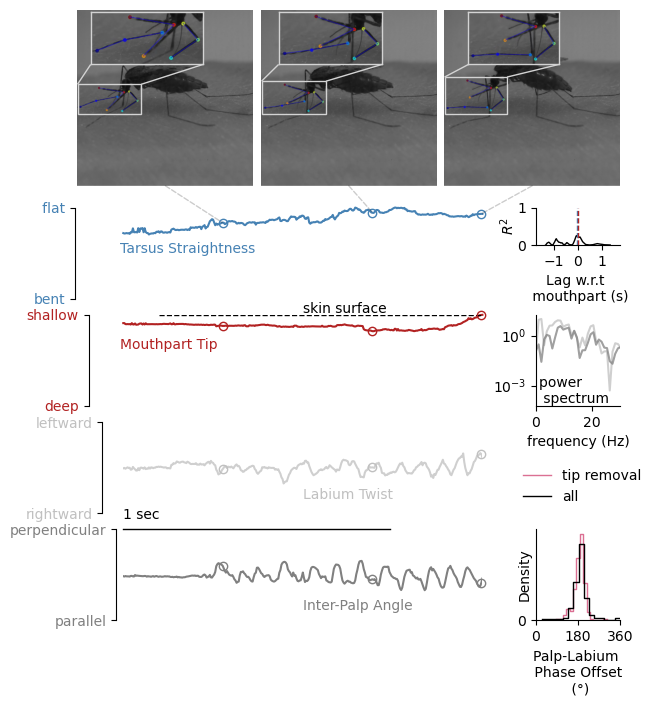

In [17]:
# === Color Settings ===
colors = {
    'insert': 'firebrick',
    'gut': 'rosybrown',
    'straight': 'steelblue',
    'twist': 'silver',
    'palp': 'grey'
}

fig = plt.figure(figsize=(7, 8))
gs = fig.add_gridspec(9, 12, width_ratios=[1]*12, height_ratios=[1]+[0.2]*8, hspace=0.3, wspace=0.2)

# === FRAME TIMEPOINTS ===
timeinterval = [0, t_bite]
timeCond = (time >= timeinterval[0]) & (time <= timeinterval[1])

# === ax_insert: Mouthpart Insert Length ===
ax_insert = fig.add_subplot(gs[3:5, 1:9])
y_insert = -bt.insert_length(derDf)
ax_insert.plot(time[timeCond], y_insert[timeCond], color=colors['insert'], clip_on=False, zorder=-1)
ax_insert.text(-np.max(time[timeCond])/100, np.min(y_insert[timeCond])-0.2, "Mouthpart Tip", fontsize=10, color=colors['insert'])
ax_insert.text(np.median(time[timeCond]), 0.02, "skin surface", fontsize=10, color='k')
ax_insert.set_xlim(0, t_bite)
ax_insert.set_ylim(-1, 0)
ax_insert.set_yticks([-1, 0])
ax_insert.spines['left'].set_position(('outward', 25))
ax_insert.set_yticklabels(['deep', 'shallow'], color = colors['insert'])
ax_insert.axhline(y=0, xmin=0.1, color='black', linewidth=1, linestyle='--')
ax_insert.set_xticks([])
sns.despine(ax=ax_insert, bottom=True)

frame_indices = datasetDf[['frame1','frame2','frame3']].iloc[videoIdx].values-int(t_bite_start*n/T) #[np.argmin(np.abs(time - t)) for t in frame_times]
frame_times = frame_indices * T/n
if np.sum((frame_times < 0) | (frame_times > t_bite))> 0:
    # Frame time indices and sorted values
    frame_times = np.sort([
        np.argmin(y_insert)*T/n,
        np.argmin(np.abs(y_insert - np.mean(y_insert)))*T/n,
        np.argmax(y_insert)*T/n
    ])
    frame_indices = [np.argmin(np.abs(time - t)) for t in frame_times]

# --- Helper function for marking frame times ---
def mark_open_circles(ax, y_data, color):
    for t in frame_times:
        idx = np.argmin(np.abs(time - t))
        ax.plot(time[idx], y_data[idx], marker='o', color=color, fillstyle='none', linewidth=1, clip_on=False)

mark_open_circles(ax_insert, y_insert, colors['insert'])

# === ax_straight: Tarsus Straightness ===
ax_straight = fig.add_subplot(gs[1:3, 1:9])
y_straight = bt.straightness(derDf)
ax_straight.plot(time[timeCond], y_straight[timeCond], color=colors['straight'], clip_on=False)
ax_straight.text(-np.max(time[timeCond])/100, np.min(y_straight[timeCond])-0.2, "Tarsus Straightness", fontsize=10, color=colors['straight'])
ax_straight.set_ylim(0, 1)
ax_straight.set_yticks([0, 1])
ax_straight.spines['left'].set_position(('outward', 35))
ax_straight.set_yticklabels(['bent', '   flat'], color = colors['straight'])
ax_straight.set_xlim(0, t_bite)
ax_straight.set_xticks([])
sns.despine(ax=ax_straight, bottom=True)
mark_open_circles(ax_straight, y_straight, colors['straight'])

# === ax_twist: Labium Twist ===
ax_twist = fig.add_subplot(gs[5:7, 1:9])
angle_lab_3d = bt.estimte_3d_labial_twist(derDf) * datasetDf['twist direction'].iloc[videoIdx]
ax_twist.plot(time[timeCond], angle_lab_3d[timeCond], color=colors['twist'], linestyle='-', alpha=0.75)
ax_twist.text(np.mean(time[timeCond]), np.min(angle_lab_3d)-30, "Labium Twist", fontsize=10, color=colors['twist'])
ax_twist.set_xlim(0, t_bite)
ax_twist.set_ylim(-90, 90)
ax_twist.set_yticks([-90, 90])
ax_twist.spines['left'].set_position(('outward', 15))
ax_twist.set_yticklabels(['rightward', 'leftward'], color=colors['twist'])
ax_twist.set_xticks([])
sns.despine(ax=ax_twist, bottom=True)
mark_open_circles(ax_twist, angle_lab_3d, colors['twist'])

# Gut Length if available
if 'gut' in derDf.columns.values[-1][0]:
    ax_gut = ax_insert.twinx()
    gl = bt.gut_length(derDf)
    ax_gut.plot(time[timeCond], gl[timeCond], color=colors['gut'], clip_on=False, zorder=-1, alpha=0.5)
    ax_gut.set_ylim(0, 1)
    ax_gut.set_yticks([0, 1])
    ax_gut.spines['right'].set_position(('outward', -5))
    mark_open_circles(ax_gut, gl, colors['gut'])
    sns.despine(ax=ax_gut, bottom=True, right=False, left=True)
    ax_gut.spines['right'].set_visible(True)
    ax_gut.set_yticklabels(['thin', 'wide'], color=colors['gut'], zorder=10)
    ax_gut.yaxis.set_ticks_position('right')
    ax_gut.yaxis.set_label_position('right')
    ax_gut.text(np.mean(time[timeCond]), np.mean(gl[timeCond])-0.2, "Gut Length", fontsize=10, color=colors['gut'])
    

# === ax_palp: Inter-Palp Angle ===
ax_palp = fig.add_subplot(gs[7:9, 1:9])
angle_pal_3d = bt.estimate_3d_palp_angle(derDf, r=1.2, segment=2)
ax_palp.plot(time[timeCond], angle_pal_3d[timeCond], color=colors['palp'], linestyle='-')
ax_palp.text(np.mean(time[timeCond]), np.min(angle_pal_3d)-20, "Inter-Palp Angle", fontsize=10, color=colors['palp'])
ax_palp.axhline(y=90, xmin=0 , xmax=1/time[timeCond].max(), clip_on=False, color='k', linewidth=1)
ax_palp.text(0, 100, "1 sec", fontsize=10, color='k')
ax_palp.set_xlim(0, t_bite)
ax_palp.set_ylim(0, 90)
ax_palp.set_yticks([0, 90])
ax_palp.spines['left'].set_position(('outward', 5))
ax_palp.set_yticklabels(['parallel', 'perpendicular'], color = colors['palp'])
ax_palp.set_xticks([])
sns.despine(ax=ax_palp, bottom=True)
mark_open_circles(ax_palp, angle_pal_3d, colors['palp'])

corrDf = pd.DataFrame(np.array([y_straight, y_insert, time, angle_lab_3d, angle_pal_3d]).T, columns=['straightness', 'insert_length', 'time [s]', 'lab_angle', 'pal_angle']).dropna()
ax_str_ins = fig.add_subplot(gs[1, 10:])
ax_str_ins.set_xlim(-1.75, 1.75)
ax_str_ins.set_ylim(0, 1)
lags, r_sq = bt.get_lag_curve(corrDf)
lag_at_max_corr = lags[np.argmax(r_sq)]
ax_str_ins.plot(lags, r_sq, color = 'k', linewidth=1)
ax_str_ins.set_xlabel('Lag w.r.t \n mouthpart (s)', fontsize =10)
ax_str_ins.set_ylabel('$R^2$', labelpad=0)
ax_str_ins.axvline(x=lag_at_max_corr, color=colors['straight'], linestyle='--', linewidth=1)
ax_str_ins.axvline(x=0, color=colors['insert'], linestyle='--', linewidth=1)
sns.despine(ax = ax_str_ins)

#checks whether there are at least 2 second long periods of tip removal or insertion
removal = bt.zoom_str_mot(corrDf, zoomInterval = t_bite/10)
insertion = bt.zoom_str_mot(corrDf, zoomInterval = t_bite/10, dir = 'insertion', mov_percentile= 80)

ax_pal_lab = fig.add_subplot(gs[7:9, 10:])
ax_pal_lab.set_xticks([0, 180, 360])

if np.sum(removal)>0:
    sns.histplot(bt.deltaPhase(corrDf, removal = True), bins = 15, ax = ax_pal_lab, element="step", stat="density", fill = False, color = 'palevioletred', linewidth=1, label = 'tip removal')
if np.sum(insertion)>0: 
    sns.histplot(bt.deltaPhase(corrDf, removal = True, dir = 'insertion', mov_percentile=80), bins = 15, ax = ax_pal_lab, element="step", stat="density", fill = False, color = 'darkmagenta', linewidth=1, label = 'tip insertion')

sns.histplot(bt.deltaPhase(corrDf), bins = 15, ax = ax_pal_lab, element="step", stat="density", fill = False, color = 'k', linewidth=1, label = 'all')

if (np.sum(removal) > 0) | (np.sum(insertion) > 0):
    ax_pal_lab.legend(loc='upper right', bbox_to_anchor = (1.4, 1.8), fontsize=10, frameon=False)
else:
    ax_pal_lab.legend([], [], frameon=False)

ax_pal_lab.set_xlabel('Palp-Labium \n Phase Offset \n (°)', fontsize=10)
ax_pal_lab.set_xlim(0, 360)
ax_pal_lab.set_yticks([0])
ax_pal_lab.set_ylabel('Density', fontsize=10, labelpad=-10)
sns.despine(ax = ax_pal_lab)

if (np.sum(removal) > 0) | (np.sum(insertion) > 0):
    ax_spec = fig.add_subplot(gs[3:5, 10:])
else:
    ax_spec = fig.add_subplot(gs[3:6, 10:])

# ax_spec gets the middle cell with more vertical space
#ax_spec = fig.add_subplot(gs[3:5, 10:])
f, Pxx_den = signal.welch(corrDf['lab_angle'], fs=n/T)
f1, Pxx_den1 = signal.welch(corrDf['pal_angle'], fs=n/T)
ax_spec.semilogy(f, Pxx_den, color=colors['twist'], linewidth=1.5, alpha=0.75)   # Horizontal log scale
ax_spec.semilogy(f1, Pxx_den1, color=colors['palp'], linewidth=1.5, alpha=0.75)   # Horizontal log scale
ax_spec.set_xlabel('frequency (Hz)')
ax_spec.set_yticks([0.001, 1])
ax_spec.text(1, np.min([np.min(Pxx_den), np.min(Pxx_den1)])*0.8, 'power \n spectrum', fontsize = 10, color = 'k')
ax_spec.set_xlim(0, 30)
sns.despine(ax = ax_spec)


removal = bt.zoom_str_mot(corrDf, zoomInterval = 1)
insertion = bt.zoom_str_mot(corrDf, zoomInterval = 1, dir = 'insertion', mov_percentile= 80)
if removal.sum() > 0:
    toplot = removal
elif insertion.sum() > 0:
    toplot = insertion
else: 
    toplot = None   
if (t_bite>8) & (toplot is not None): 
    for ax, col, key, anchor in [(ax_palp, 'palp', 'pal_angle', -0.1), (ax_twist, 'twist', 'lab_angle', 0.1)]:
        # Get time range
        t_start = corrDf['time [s]'][toplot].min()
        t_end = corrDf['time [s]'][toplot].max()

        # Add inset
        ax_in = inset_axes(ax, width="30%", height="30%", bbox_to_anchor=(0.6, anchor, 1, 1),
                        bbox_transform=ax.transAxes, loc='upper left', borderpad=0)
        ax_in.plot(corrDf['time [s]'][toplot], corrDf[key][toplot], color=colors[col], alpha=0.7)
        ax_in.set_xlim(t_start, t_end)
        ax_in.set_ylim(corrDf[key][toplot].min(), corrDf[key][toplot].max())
        ax_in.set_xticks([]); ax_in.set_yticks([]); ax_in.set_facecolor('white')
        [s.set_edgecolor('palevioletred') for s in ax_in.spines.values()] if removal.sum() > 0 else [s.set_edgecolor('darkmagenta') for s in ax_in.spines.values()]

        # Highlight zoom region on main plot
        v0, v1 = corrDf[key][toplot].min(), corrDf[key][toplot].max()
        ax.axvspan(t_start, t_end, ymin=(v0-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]),
                        ymax=(v1-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]),
                        fill = False, edgecolor='palevioletred', linewidth=1) if removal.sum() > 0 else \
            ax.axvspan(t_start, t_end, ymin=(v0-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]),
                        ymax=(v1-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]),
                        fill = False, edgecolor='darkmagenta', linewidth=1)
        

# === Video Stills with Insets ===
for i, (t, frame) in enumerate(zip(frame_times, frame_indices)):
    ax_vid = fig.add_subplot(gs[0, 4*i:4*(i+1)])
    ax_vid.imshow(video_bite[frame])
    ax_vid.axis('off')

    # Zoom inset
    idx = np.argmin(np.abs(time - t)) + t_bite_start*n/T
    partslist = tuple(pd.Series(parts)[pd.Series(parts).str.contains('lab|pal|tar')].tolist())
    x1 = legDf.loc[idx, (partslist, 'x')].min() - 20
    x2 = legDf.loc[idx, (partslist, 'x')].max() + 20
    y1 = legDf.loc[idx, (partslist, 'y')].min() - 20
    y2 = legDf.loc[idx, (partslist, 'y')].max() + 20

    axins = inset_axes(ax_vid, width='75%', height='30%', loc='upper left', bbox_to_anchor=[0.02, -0.01, 1, 1], bbox_transform=ax_vid.transAxes, borderpad=0)
    axins.imshow(video_bite[frame])
    axins.set_xlim(x1, x2)
    axins.set_ylim(y2, y1)
    axins.set_xticks([]); axins.set_yticks([])
    axins.set_facecolor('lightgrey')
    for spine in axins.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linewidth(1)
    mark_inset(ax_vid, axins, loc1=3, loc2=4, fc="none", ec="lightgrey", lw=1, zorder=0)

    # Connection to time series
    con = ConnectionPatch(xyA=(len(video_bite[0])//2, len(video_bite[0])),
                          xyB=(t, y_straight[frame]), coordsB=ax_straight.transData,
                          axesA=ax_vid, axesB=ax_straight, coordsA=ax_vid.transData,
                          color='k', linewidth=1, linestyle='--', alpha=0.2)
    fig.add_artist(con)
plt.savefig(plot_folder + f"panel_{videoIdx}.pdf", bbox_inches='tight', dpi=300)

In [18]:
playbackspeed = 1 #x

# --- Setup ---
colors = {
    'insert': 'firebrick',
    'gut': 'rosybrown',
    'straight': 'steelblue',
    'twist': 'silver',
    'palp': 'grey'
}

fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(9, 12, width_ratios=[1]*12, height_ratios=[2]+[0.2]*8, hspace=0.3, wspace=0.2)

# === Video frame (top row, middle cells) ===
ax_vid = fig.add_subplot(gs[0, :])
ax_vid.set_title(f'{playbackspeed}x speed', fontsize = 10)
im = ax_vid.imshow(video_bite[0])
ax_vid.axis('off')

# === Time-Series Axes ===
# Mouthpart Insertion
ax_insert = fig.add_subplot(gs[3:5, :])
line_insert, = ax_insert.plot([], [], color=colors['insert'], clip_on=False)
ax_insert.set_xlim(0, t_bite)
ax_insert.set_ylim(-1, 0)
ax_insert.set_yticks([-1, 0])
ax_insert.set_yticklabels(['deep', 'shallow'], color=colors['insert'])
ax_insert.axhline(y=0, xmin=0.1, color='black', linewidth=1, linestyle='--')
ax_insert.text(np.mean(time[timeCond]), np.min(y_insert[timeCond])-0.2, "Mouthpart Tip", fontsize=10, color=colors['insert'])
ax_insert.text(np.median(time[timeCond]), 0.02, "skin surface", fontsize=10, color='k')
ax_insert.set_xticks([])
sns.despine(ax=ax_insert, bottom=True)

# Tarsus Straightness
ax_straight = fig.add_subplot(gs[1:3, :])
line_straight, = ax_straight.plot([], [], color=colors['straight'], clip_on=False)
ax_straight.set_xlim(0, t_bite)
ax_straight.set_ylim(0, 1)
ax_straight.set_yticks([0, 1])
ax_straight.set_yticklabels(['bent', '   flat'], color=colors['straight'])
ax_straight.text(np.mean(time[timeCond]), np.min(y_straight[timeCond])-0.2, "Tarsus Straightness", fontsize=10, color=colors['straight'])
ax_straight.set_xticks([])
sns.despine(ax=ax_straight, bottom=True)

# Labium Twist
ax_twist = fig.add_subplot(gs[5:7, :])
line_twist, = ax_twist.plot([], [], color=colors['twist'], linestyle='-', alpha=0.75)
ax_twist.set_xlim(0, t_bite)
ax_twist.set_ylim(-90, 90)
ax_twist.set_yticks([-90, 90])
ax_twist.set_yticklabels(['rightward', 'leftward'], color=colors['twist'])
ax_twist.text(np.mean(time[timeCond]), np.min(angle_lab_3d)-30, "Labium Twist", fontsize=10, color=colors['twist'])
ax_twist.set_xticks([])
sns.despine(ax=ax_twist, bottom=True)

# Inter-Palp Angle
ax_palp = fig.add_subplot(gs[7:9, :])
line_palp, = ax_palp.plot([], [], color=colors['palp'], linestyle='-')
ax_palp.set_xlim(0, t_bite)
ax_palp.set_ylim(0, 90)
ax_palp.set_yticks([0, 90])
ax_palp.set_yticklabels(['parallel', 'perpendicular'], color=colors['palp'])
ax_palp.text(np.mean(time[timeCond]), np.min(angle_pal_3d)-20, "Inter-Palp Angle", fontsize=10, color=colors['palp'])
ax_palp.set_xticks([])
sns.despine(ax=ax_palp, bottom=True)


# Optional Gut Length if available
has_gut = 'gut' in derDf.columns.values[-1][0]
if has_gut:
    ax_gut = ax_insert.twinx()
    line_gut, = ax_gut.plot([], [], color=colors['gut'], alpha=0.5)
    ax_gut.set_ylim(0, 1)
    ax_gut.set_yticks([0, 1])
    ax_gut.set_yticklabels(['thin', 'wide'], color=colors['gut'])
    ax_gut.yaxis.set_ticks_position('right')
    ax_gut.text(np.mean(time[timeCond]), np.mean(gl[timeCond])-0.2, "Gut Length", fontsize=10, color=colors['gut'])
    sns.despine(ax=ax_gut, bottom=True, right=False, left=True)
    ax_gut.spines['right'].set_visible(True)
    ax_gut.yaxis.set_ticks_position('right')
    ax_gut.yaxis.set_label_position('right')

# Data
y_insert = -bt.insert_length(derDf)
y_straight = bt.straightness(derDf)
y_twist = bt.estimte_3d_labial_twist(derDf) * datasetDf['twist direction'].iloc[videoIdx]
y_palp = bt.estimate_3d_palp_angle(derDf, r=1.2, segment=2)
if has_gut:
    y_gut = bt.gut_length(derDf)

# === Animation Function ===
def animate(i):
    im.set_array(video_bite[i])
    line_insert.set_data(time[:i], y_insert[:i])
    line_straight.set_data(time[:i], y_straight[:i])
    line_twist.set_data(time[:i], y_twist[:i])
    line_palp.set_data(time[:i], y_palp[:i])
    if has_gut:
        line_gut.set_data(time[:i], y_gut[:i])
    return [im, line_insert, line_straight, line_twist, line_palp] + ([line_gut] if has_gut else [])

# === Create Animation ===
ani = animation.FuncAnimation(
    fig, animate,
    frames=np.arange(0, len(time), 5),
    interval=5*T/n*1000/playbackspeed,  # 1 x play speed
    repeat=False
)

# === Display in Notebook ===
html = HTML(ani.to_html5_video())
display(html)
plt.close()

# === Optional Save ===
ani.save(plot_folder + f"panel_{videoIdx}_playback_{playbackspeed}x.mp4", fps=n/(T*5)*playbackspeed, dpi=300, extra_args=['-vcodec', 'libx264'])